In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
import glob
import matplotlib.pyplot as plt
import torchvision

In [114]:
print(torch.__version__)

1.13.1


In [115]:
print(torch.cuda.is_available())

True


In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Layer 정의

In [117]:
class Block(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(Block, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias = True, padding_mode = 'reflect'),
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
  def forward(self, x):
    return self.conv(x)

In [118]:
class Discriminator(nn.Module):
  def __init__(self, in_channels = 3, features = [64, 128, 256, 512]):
    super(Discriminator, self).__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels, features[0], kernel_size = 4, stride = 2, padding = 1, padding_mode ='reflect'), # Conv(3, 64, 4, 2, 1)
    nn.LeakyReLU(0.2))

    layers = []
    in_channels = features[0]
    for feature in features[1:]:
      layers.append(Block(in_channels, feature, stride = 1 if feature == features[-1] else 2)) #Conv(64,128, 4, 2, 1),Conv(128,256, 4, 2, 1), Conv(256, 512, 4, 1, 1)  담는다
      in_channels = feature # 
    layers.append(nn.Conv2d(in_channels,1, kernel_size = 4, stride = 1, padding = 1, padding_mode = 'reflect')) #Conv(512, 1, 4, 1, 1)
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    x = self.initial(x)
    return torch.sigmoid(self.model(x)) # 30 x 30 pathgan

In [119]:
x = torch.randn((5, 3, 256, 256))
model = Discriminator(in_channels = 3)
preds = model(x)
print(preds.shape)
print(preds[0][0])

torch.Size([5, 1, 30, 30])
tensor([[0.4859, 0.4802, 0.4359, 0.3682, 0.6482, 0.5030, 0.4125, 0.4180, 0.3972,
         0.4419, 0.3824, 0.4138, 0.6777, 0.5447, 0.3553, 0.4423, 0.4557, 0.4297,
         0.4845, 0.5777, 0.6364, 0.3434, 0.3021, 0.5146, 0.5929, 0.5183, 0.5951,
         0.4424, 0.3402, 0.3805],
        [0.4872, 0.5142, 0.4405, 0.5667, 0.4608, 0.5000, 0.4109, 0.3994, 0.3265,
         0.5426, 0.4804, 0.5995, 0.6654, 0.5647, 0.2939, 0.3733, 0.4460, 0.3929,
         0.5497, 0.4315, 0.4861, 0.4180, 0.5565, 0.5336, 0.3849, 0.5747, 0.5026,
         0.4741, 0.4474, 0.5265],
        [0.3213, 0.6125, 0.4813, 0.3036, 0.5442, 0.3196, 0.3498, 0.4346, 0.5151,
         0.4077, 0.4577, 0.6413, 0.4903, 0.6038, 0.3648, 0.3962, 0.3921, 0.5149,
         0.3853, 0.4955, 0.4955, 0.4014, 0.2843, 0.4130, 0.6581, 0.4279, 0.5624,
         0.4925, 0.5502, 0.6127],
        [0.5818, 0.4128, 0.6489, 0.3187, 0.4879, 0.4966, 0.3886, 0.3963, 0.3484,
         0.4679, 0.3760, 0.4232, 0.5894, 0.6256, 0.3816, 0.30

In [120]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, down = True, use_act = True, **kwargs):
    super(ConvBlock, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, padding_mode = 'reflect', **kwargs)
        if down else 
        nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(inplace = True) if use_act else nn.Identity()
    )
  def forward(self, x):
    return self.conv(x)

In [121]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
      ConvBlock(channels, channels, kernel_size = 3, padding = 1),
      ConvBlock(channels, channels, use_act = False, kernel_size = 3, padding = 1)
  )
  def forward(self, x):
    return x + self.block(x)

### 생성기 정의

In [122]:
class Generator(nn.Module):
  def __init__(self, img_channels,num_features = 64, num_resblock = 9):
    super(Generator, self).__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(img_channels, num_features, kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect'),
        nn.ReLU(inplace = True)
    )
    self.down_blocks = nn.ModuleList(
      [
          ConvBlock(num_features, num_features * 2, kernel_size = 3, stride = 2, padding = 1),
       ConvBlock(num_features * 2, num_features * 4, kernel_size = 3, stride = 2, padding = 1),]
    )
    self.residual_block = nn.Sequential(
        *[ResidualBlock(num_features * 4) for _ in range(num_resblock)]
    )

    self.up_blocks = nn.ModuleList(
        [
        ConvBlock(num_features * 4, num_features * 2, down = False, kernel_size = 3, stride = 2,padding = 1, output_padding = 1),
        ConvBlock(num_features * 2, num_features, down = False, kernel_size = 3, stride = 2,padding = 1, output_padding = 1)
    ])
    
    self.last = nn.Conv2d(num_features * 1, img_channels, kernel_size = 7, stride = 1, padding = 3, padding_mode = 'reflect')
  
  def forward(self, x):
    x = self.initial(x)
    for layer in self.down_blocks:
      x = layer(x)
    x= self.residual_block(x)
    for layer in self.up_blocks:
      x = layer(x)
    
    return torch.tanh(self.last(x))

In [123]:
test = torch.randn(2, 3, 256, 256)
gen = Generator(3)
print(gen(test).shape)

torch.Size([2, 3, 256, 256])


In [124]:
transforms_ = [transforms.Resize((256, 256)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
test_trans = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### 데이터셋은 celeb attribute

In [125]:
class Custom_Dataset(Dataset):
  def __init__(self, root, transforms_ = None, mode = 'train'):
    self.transforms = transforms.Compose(transforms_)
    
    self.file_A = sorted(glob.glob(os.path.join(root, 'trainA') + '/*')) 
    self.file_B = sorted(glob.glob(os.path.join(root, 'trainB') + '/*'))
  
  def __getitem__(self, index):
    itemA = self.transforms(Image.open(self.file_A[index % len(self.file_A)]))
    itemB = self.transforms(Image.open(self.file_B[index % len(self.file_B)]))

    return {'A' : itemA, 'B' : itemB}

  def __len__(self):
    return max(len(self.file_A), len(self.file_B))  

In [126]:
root= "C:\\Users\\User\\Desktop\\GAN proj\\archive\\img_align_celeba\\dataAB\\"
#root = "D:\\다운로드\\archive\\dataAB\\"
batch_size = 32
learning_rate = 2e-4
lambda_identity = 0
lambda_cycle = 10
num_epochs = 200

In [127]:
disc_H = Discriminator(in_channels = 3).to(device)
disc_Z = Discriminator(in_channels = 3).to(device)
gen_Z = Generator(img_channels = 3, num_resblock = 9).to(device)
gen_H = Generator(img_channels = 3, num_resblock = 9).to(device)

optim_disc = optim.Adam(list(disc_H.parameters()) + list(disc_Z.parameters()),
                        lr = learning_rate, betas = (0.5, 0.999))
optim_gen = optim.Adam(list(gen_Z.parameters()) + list(gen_H.parameters()),
                       lr = learning_rate, betas = (0.5, 0.999))
L1 = nn.L1Loss()
mse = nn.MSELoss()

In [128]:
dataset = Custom_Dataset(
     root, transforms_ = transforms_
)
dataloader = DataLoader(dataset, batch_size = 2, shuffle = True)

In [129]:
imagea = next(iter(dataloader))['A'][0]
imageb = next(iter(dataloader))['B'][0]

In [130]:
imagea

tensor([[[ 0.2706,  0.2706,  0.2627,  ..., -0.1451, -0.1451, -0.1451],
         [ 0.2784,  0.2784,  0.2706,  ..., -0.1608, -0.1608, -0.1608],
         [ 0.2863,  0.2863,  0.2784,  ..., -0.1059, -0.1059, -0.1059],
         ...,
         [-0.1294, -0.1294, -0.1373,  ...,  0.8902,  0.9294,  0.9686],
         [-0.1216, -0.1216, -0.1294,  ...,  0.8510,  0.8980,  0.9373],
         [-0.1843, -0.1843, -0.1922,  ...,  0.8510,  0.8980,  0.9373]],

        [[ 0.4745,  0.4745,  0.4824,  ...,  0.3804,  0.3804,  0.3804],
         [ 0.4824,  0.4824,  0.4824,  ...,  0.3490,  0.3490,  0.3569],
         [ 0.4745,  0.4745,  0.4824,  ...,  0.3804,  0.3804,  0.3804],
         ...,
         [-0.0745, -0.0745, -0.0745,  ...,  0.1059,  0.1451,  0.1843],
         [-0.0667, -0.0667, -0.0667,  ...,  0.0588,  0.1059,  0.1451],
         [-0.1294, -0.1294, -0.1294,  ...,  0.0431,  0.0902,  0.1294]],

        [[ 0.5765,  0.5765,  0.5765,  ...,  0.5922,  0.5922,  0.5922],
         [ 0.5843,  0.5843,  0.5843,  ...,  0

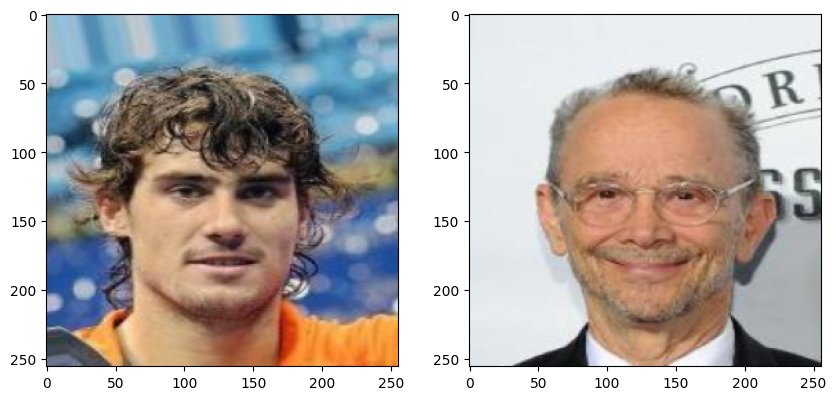

In [131]:
plt.figure(figsize = (10, 10))
plt.subplot(1,2,1)
plt.imshow(torchvision.utils.make_grid(imagea, normalize = True).permute(1, 2, 0)) #a 안경 X
plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid(imageb, normalize = True).permute(1, 2, 0)) #b 안경 O

In [132]:
print(imagea.size())
print(imageb.size())

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


In [133]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [134]:
# disc_H = Discriminator(in_channels = 3).to(device) = disc_A
# disc_Z = Discriminator(in_channels = 3).to(device) = disc_O
# gen_Z = Generator(img_channels = 3, num_resblock = 9).to(device) = gen_O
# gen_H = Generator(img_channels = 3, num_resblock = 9).to(device) = gen_A
# zebra = orange, horse = apple

for epoch in range(num_epochs):
  for idx, batch in enumerate(dataloader):
  
    orange = batch['B'].to(device)
    apple = batch['A'].to(device)
    optim_disc.zero_grad()
    optim_gen.zero_grad()

    fake_apple = gen_H(orange) 
    D_A_real = disc_H(apple) 
    D_A_fake = disc_H(fake_apple.detach()) 
    D_A_real_loss = mse(D_A_real, torch.ones_like(D_A_real))
    D_A_fake_loss = mse(D_A_fake, torch.zeros_like(D_A_fake)) 
    D_A_loss = D_A_real_loss + D_A_fake_loss 

    fake_orange = gen_Z(apple)
    D_O_real = disc_Z(orange)
    D_O_fake = disc_Z(fake_orange.detach())
    D_O_real_loss = mse(D_O_real, torch.ones_like(D_O_real))
    D_O_fake_loss = mse(D_O_fake, torch.zeros_like(D_O_fake))
    D_O_loss = D_O_real_loss + D_O_fake_loss

    D_loss = (D_A_loss + D_O_loss) / 2

    D_loss.backward()
    optim_disc.step()
    #generator 학습
    D_A_fake = disc_H(fake_apple)
    D_O_fake = disc_Z(fake_orange)
    loss_G_A = mse(D_O_fake, torch.ones_like(D_A_fake)) #CE 를 쓰지않고 여기서 정의된 새로운 손실함수 
    loss_G_O = mse(D_O_fake, torch.ones_like(D_O_fake))

    cycle_orange = gen_Z(fake_apple)
    cycle_apple = gen_H(fake_orange)
    cycle_orange_loss = L1(orange, cycle_orange)
    cycle_apple_loss = L1(apple, cycle_apple)

    identity_orange = gen_Z(orange)
    identity_apple = gen_H(apple)
    identity_orange_loss = L1(orange, identity_orange)
    identity_apple_loss = L1(apple, identity_apple)

    G_loss = (loss_G_O + loss_G_A + cycle_orange_loss * lambda_cycle + cycle_apple_loss * lambda_cycle
              +identity_apple_loss * lambda_identity + identity_orange_loss * lambda_identity)
    G_loss.backward()
    optim_gen.step()
    if idx == 50:
      print('EPOCH : ', epoch, 'G_loss : ', G_loss, 'D_loss :', D_loss)
      break

EPOCH :  0 G_loss :  tensor(5.7205, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.4701, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  1 G_loss :  tensor(4.3510, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.4854, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  2 G_loss :  tensor(4.5455, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.4597, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  3 G_loss :  tensor(5.0049, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.3761, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  4 G_loss :  tensor(5.9259, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.2384, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  5 G_loss :  tensor(4.6643, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.2586, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH :  6 G_loss :  tensor(3.7917, device='cuda:0', grad_fn=<AddBackward0>) D_loss : tensor(0.2800, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH 

### 모델 저장

In [135]:
torch.save(gen_H, 'gen_H.pth')
torch.save(gen_Z, 'gen_Z.pth')

In [136]:
apple_image = next(iter(dataloader))['A'][1]
orange_image = next(iter(dataloader))['B'][1]

In [137]:
apple_image = apple_image.to(device)
orange_image = orange_image.to(device)

모델에 이미지 넣어서 결과 확인.
나름 잘 변환된 것을 확인할 수 있다.

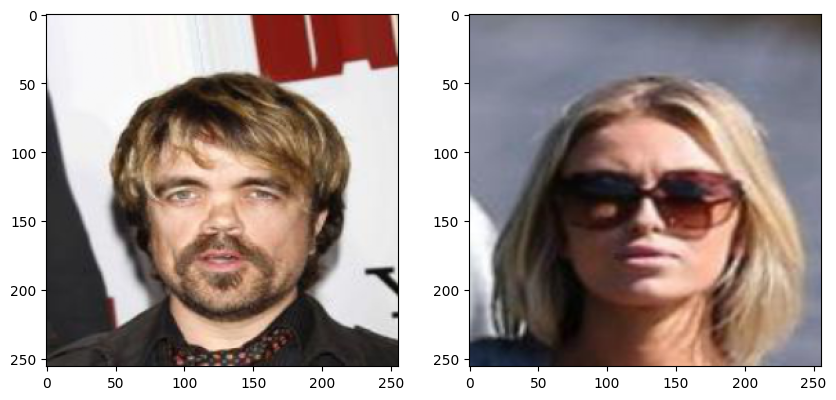

In [138]:
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(torchvision.utils.make_grid(apple_image.cpu(), normalize = True).permute(1, 2, 0)) 
plt.subplot(1,2,2)
plt.imshow(torchvision.utils.make_grid(orange_image.cpu(), normalize = True).permute(1, 2, 0)) 

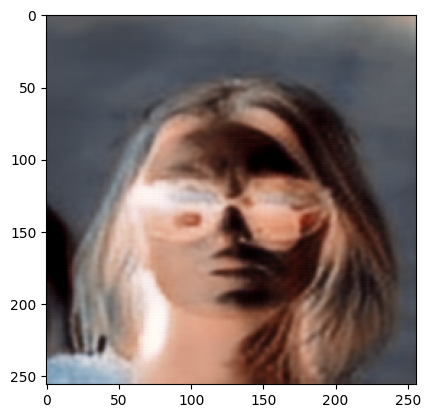

In [139]:
trans_apple = gen_H(orange_image).cpu()
plt.imshow(torchvision.utils.make_grid(trans_apple.cpu(), normalize = True).permute(1, 2, 0)) 

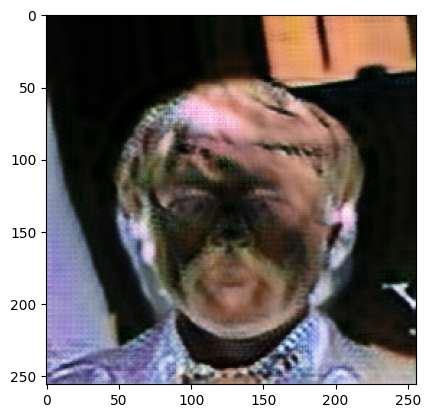

In [140]:
trans_orange = gen_Z(apple_image).cpu()
plt.imshow(torchvision.utils.make_grid(trans_orange.cpu(), normalize = True).permute(1, 2, 0)) 